## <center> Calculating Relative Humidity </center>

In [1]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func

### Equations for calculating RH from specific humidity
We will be estimating RH as: (per Byrne 2021 - although done with percentiles but I think its fine...)
$$r = \dfrac{q}{q^*}$$

We can derive q from huss variable for all models, leaving us needing to calculate $q^*$ Saturation Specific Humidity. Specific humidity is just the ratio of the total mass of water vapor to the total mass of air: this came from (https://pressbooks-dev.oer.hawaii.edu/atmo/chapter/chapter-4-water-vapor/)

$$q^* = \dfrac{\epsilon \cdot e^*}{P - e \cdot (1-\epsilon)}$$

And then we have to get $e^*$ the saturation vapor pressure which we can use a simplification of the clausius clayperon relationship:
$$e^* = 0.6113exp(\dfrac{L_v}{R_v}(\dfrac{t}{T_0} - \dfrac{1}{T}))$$

##### On reflection- Looking at Global Global Climate lecture slide...
In the lecture slide it says that RH is well estimated by:
$$ r = \dfrac{e}{e^*} \approx \dfrac{q}{q^*}$$
Where $e^*$:
$$ e^* = Aexp(\alpha T)$$
Where  A = 611Pa and $\alpha$ = 0.0067C
So the problem of having to pull in surface pressures - which are potentially messed up by sealevel pressure vs actual surface pressure would be solved by this
Be care bc specific humidity is expresses as a 1/1 ie kg/kg in the models where these formulas will be g/kg

**We still need an expression for $e$ however...**

In [2]:
## Simpler calculations for RH
def calcRH(temp, specificHumidity):
    '''
    temp in K
    specific humidity in kg/kg
    '''
    Esat = 611*np.exp(0.0067*temp) /1000
    RHestimate = specificHumidity/Esat # its not the actual values its the ratio between them that is equal so we'd still need 
    return RHestimate
    

In [3]:
# First step is calculating esat from temperature

def calcEsat(temp):
    '''
    temp must be provided in K
    results returned in Pa
    '''
    return (0.6113 * np.exp(2500000/461*((1/273.15)-(1/temp))))*1000

# Going between Esat and Qsat - bringing in pressure
def calcQsat(temp, pressure):
    '''
    temp provided in K, pressure in Pa
    results returned in kg kg-1 ie 1
    '''
    Esat = calcEsat(temp)/1000 #in kPa
    eps = 0.622
    
    return (eps*Esat) / ((pressure/1000) - (Esat*(1-eps)))

# And finally calculating relative humidity
def calcRH(temp, pressure, specificHumidity):
    '''
    temp provided in K, pressure in Pa, specific humidity in kg kg-1
    RH is returned as 0-100%
    '''
    return specificHumidity / calcQsat(temp, pressure)*100
    

### <center>Testing the Validity of Our RH Estimates </center>

Hey Mike, I was wondering if there is a typical way of getting between saturation vapour pressure and saturation specific humidity without using surface pressure (its not included in all models) I have done it with pressure at sea level and the correlation is pretty good but not perfect was wondering if theres a better way of doing it

In [6]:
model = 'KACE-1-0-G'
period = 'ssp245'
# Note this is only grabbing the first dataset to speed things up
tas = xr.open_mfdataset(func.getVariable('tas', model, period)).tas
huss = xr.open_mfdataset(func.getVariable('huss', model, period)).huss
hurs = xr.open_mfdataset(func.getVariable('hurs', model, period)).hurs
psl = xr.open_mfdataset(func.getVariable('psl', model, period)).psl

join = xr.merge([tas, huss, hurs, psl])
del tas, huss, hurs, psl   # Keep the workspace clean!
join = func.regionTimeCut(join, period)
join = func.addLandMask(join)

join['RHestimate'] = xr.apply_ufunc(calcRH,  join['tas'], join['psl'], join['huss'], dask = 'parallelized')

In [51]:
### Applying percentile function at multiple percentiles


join['per5'] = xr.apply_ufunc(
    lambda x: np.nanpercentile(x, 5, axis=-1), join.tas, input_core_dims=[["time"]], dask = 'parallelized'
)


In [68]:
percentiles = np.arange(5,105, 5)
percentile_labels = [f"P_{p}" for p in percentiles]

join['percentiles'] = xr.apply_ufunc(
    lambda x: np.nanpercentile(x, percentiles, axis=-1),
    join.tas,
    input_core_dims=[["time"]],
    output_core_dims=[["percentile"]],
    dask_gufunc_kwargs = {'output_sizes':{"percentile": len(percentiles)},
                        'allow_rechunk':True},
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)
join['percentiles'] = join['percentiles'].assign_coords(percentile=percentiles,)


In [ ]:
plt.scatter(xr.where(join['landseamask'] == 0, join['hurs'], np.nan).values.flatten(), xr.where(join['landseamask'] == 0, join['RHestimate'], np.nan).values.flatten(),alpha = 0.1, c = 'r')
plt.scatter(xr.where(join['landseamask'] == 1, join['hurs'], np.nan).values.flatten(), xr.where(join['landseamask'] == 1, join['RHestimate'], np.nan).values.flatten(),alpha = 0.1, c = 'b')

stats.pearsonr(join.hurs.values.flatten(), join.RHestimate.values.flatten())
plt.axis('equal')

---
---
---

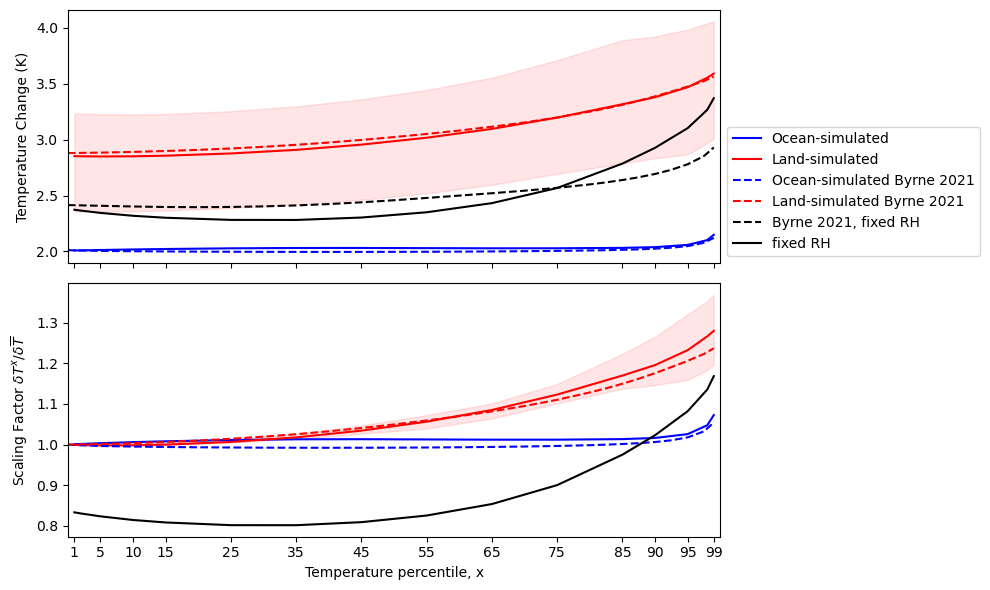

In [36]:
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

df = pd.DataFrame({})
for model in modelNames.ModelName:
    df_add = pd.read_csv(f'Fixed_RH_Theory_{model}_mal.csv')
    df = pd.concat([df, df_add])

df.to_csv('Fixed_RH_Theory_All_mal.csv', index = False)



Show_Byrne = True
doFixRH = True
## Reloading Data and Calculating Scaling factors and quantiles
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

###----------------------------------------------------------------------------------------------------------------------------------###
#        Processing percentileDifferences_all_flt.csv
###----------------------------------------------------------------------------------------------------------------------------------### 

df = pd.read_csv(f'percentileDifferences_all_flt.csv')
df['tChange_sf'] = df.tChange/df.meanChangeRg

df_mean = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.mean()
df_mean[['q1', 'q3']] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                              q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]

df_mean['sf_mean'] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange_sf.mean().tChange_sf
df_mean[['sf_q1', 'sf_q3']] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange_sf.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                              q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]
df_mean.head()

###----------------------------------------------------------------------------------------------------------------------------------###
#       Plotting your own data to recreate Figure 2 from Byrne 2021
###----------------------------------------------------------------------------------------------------------------------------------### 
# Initalize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex = True)

#ax1
ax1.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.q1[df_mean['landOcean'] == 1], df_mean.q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
for i in [0,1]:
    ax1.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.tChange[df_mean['landOcean'] == i], color = ['b', 'r'][i], label = ['Ocean-simulated', 'Land-simulated'][i])

#ax2
ax2.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.sf_q1[df_mean['landOcean'] == 1], df_mean.sf_q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
for i in [0,1]:
    ax2.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.sf_mean[df_mean['landOcean'] == i], color = ['b', 'r'][i])
###----------------------------------------------------------------------------------------------------------------------------------###
#     Processing Byrne 2021 Data
###----------------------------------------------------------------------------------------------------------------------------------### 
if Show_Byrne:
    df_Byrne = pd.read_csv('41561_2021_828_MOESM4_ESM.csv')
    
    for i in [0,1]:
        ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne[['Panel (a): Y data (solid blue line)', 'Panel (a): Y data (solid red line)'][i]], color = ['b', 'r'][i], label = ['Ocean-simulated Byrne 2021', 'Land-simulated Byrne 2021'][i], linestyle = '--')
        ax2.plot(df_Byrne['Panel (b): X data'], df_Byrne[['Panel (b): Y data (solid blue line)', 'Panel (b): Y data (solid red line)'][i]], color = ['b', 'r'][i], linestyle = '--')
    
    if doFixRH: ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne['Panel (a): Y data (dotted black line)'], c = 'k', linestyle = '--', label = 'Byrne 2021, fixed RH')

###----------------------------------------------------------------------------------------------------------------------------------###
#    Processing our fixRH calculations of dT_L^x
###----------------------------------------------------------------------------------------------------------------------------------### 
if doFixRH:
    Fix_RH = pd.read_csv(f'Fixed_RH_Theory_All_mal.csv')
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).dT_L_x.mean()
    ax1.plot(Fix_RH_means.percentile, Fix_RH_means.dT_L_x, c = 'k', label = 'fixed RH')

    df = pd.read_csv(f'percentileDifferences_all_flt.csv')
    df = df.query('landOcean == 1').reset_index(drop=True)
    
    Fix_RH['tChange_sf'] = Fix_RH.dT_L_x/df.meanChangeRg
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).tChange_sf.mean()
    ax2.plot(Fix_RH_means.percentile, Fix_RH_means.tChange_sf, c = 'k')

#Labels, Axis, legend
ax1.legend(loc = 3, bbox_to_anchor = (1, 0))

ax1.set_xlim(0,100)
ax1.set_ylabel('Temperature Change (K)')
ax2.set_ylabel('Scaling Factor $\delta T^x / \delta \overline{T}$')
ax2.set_xlabel('Temperature percentile, x')
ax2.set_xticks(df_mean.percentile[df_mean['landOcean'] == 1][~df_mean.percentile[df_mean['landOcean'] == 1].isin([2,98])])
fig.tight_layout()
fig.show()


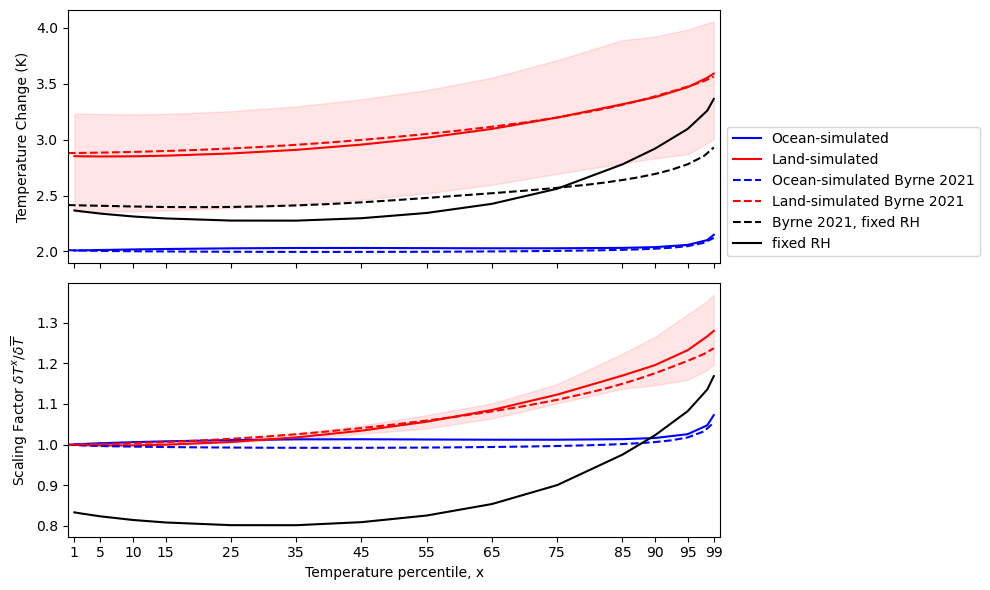

In [40]:
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
df = pd.DataFrame({})
for model in modelNames.ModelName:
    df_add = pd.read_csv(f'Fixed_RH_Theory_{model}_msam.csv')
    df = pd.concat([df, df_add])

df.to_csv('Fixed_RH_Theory_All_msam.csv', index = False)



Show_Byrne = True
doFixRH = True
## Reloading Data and Calculating Scaling factors and quantiles
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

###----------------------------------------------------------------------------------------------------------------------------------###
#        Processing percentileDifferences_all_flt.csv
###----------------------------------------------------------------------------------------------------------------------------------### 

df = pd.read_csv(f'percentileDifferences_all_flt.csv')
df['tChange_sf'] = df.tChange/df.meanChangeRg

df_mean = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.mean()
df_mean[['q1', 'q3']] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                              q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]

df_mean['sf_mean'] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange_sf.mean().tChange_sf
df_mean[['sf_q1', 'sf_q3']] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange_sf.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                              q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]
df_mean.head()

###----------------------------------------------------------------------------------------------------------------------------------###
#       Plotting your own data to recreate Figure 2 from Byrne 2021
###----------------------------------------------------------------------------------------------------------------------------------### 
# Initalize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex = True)

#ax1
ax1.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.q1[df_mean['landOcean'] == 1], df_mean.q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
for i in [0,1]:
    ax1.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.tChange[df_mean['landOcean'] == i], color = ['b', 'r'][i], label = ['Ocean-simulated', 'Land-simulated'][i])

#ax2
ax2.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.sf_q1[df_mean['landOcean'] == 1], df_mean.sf_q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
for i in [0,1]:
    ax2.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.sf_mean[df_mean['landOcean'] == i], color = ['b', 'r'][i])
###----------------------------------------------------------------------------------------------------------------------------------###
#     Processing Byrne 2021 Data
###----------------------------------------------------------------------------------------------------------------------------------### 
if Show_Byrne:
    df_Byrne = pd.read_csv('41561_2021_828_MOESM4_ESM.csv')
    
    for i in [0,1]:
        ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne[['Panel (a): Y data (solid blue line)', 'Panel (a): Y data (solid red line)'][i]], color = ['b', 'r'][i], label = ['Ocean-simulated Byrne 2021', 'Land-simulated Byrne 2021'][i], linestyle = '--')
        ax2.plot(df_Byrne['Panel (b): X data'], df_Byrne[['Panel (b): Y data (solid blue line)', 'Panel (b): Y data (solid red line)'][i]], color = ['b', 'r'][i], linestyle = '--')
    
    if doFixRH: ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne['Panel (a): Y data (dotted black line)'], c = 'k', linestyle = '--', label = 'Byrne 2021, fixed RH')

###----------------------------------------------------------------------------------------------------------------------------------###
#    Processing our fixRH calculations of dT_L^x
###----------------------------------------------------------------------------------------------------------------------------------### 
if doFixRH:
    Fix_RH = pd.read_csv(f'Fixed_RH_Theory_All_msam.csv')
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).dT_L_x.mean()
    ax1.plot(Fix_RH_means.percentile, Fix_RH_means.dT_L_x, c = 'k', label = 'fixed RH')

    df = pd.read_csv(f'percentileDifferences_all_flt.csv')
    df = df.query('landOcean == 1').reset_index(drop=True)
    
    Fix_RH['tChange_sf'] = Fix_RH.dT_L_x/df.meanChangeRg
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).tChange_sf.mean()
    ax2.plot(Fix_RH_means.percentile, Fix_RH_means.tChange_sf, c = 'k')

#Labels, Axis, legend
ax1.legend(loc = 3, bbox_to_anchor = (1, 0))

ax1.set_xlim(0,100)
ax1.set_ylabel('Temperature Change (K)')
ax2.set_ylabel('Scaling Factor $\delta T^x / \delta \overline{T}$')
ax2.set_xlabel('Temperature percentile, x')
ax2.set_xticks(df_mean.percentile[df_mean['landOcean'] == 1][~df_mean.percentile[df_mean['landOcean'] == 1].isin([2,98])])
fig.tight_layout()
fig.show()


In [48]:
import glob
import os

# Specify the directory path
directory_path = "/home/users/chingosa/CMIP6"

# Get all files in the directory that contain 'mapK' in their filenames
mapK_files = glob.glob(os.path.join(directory_path, "*q_and_t*"))

# Print the list of matching files
df = pd.DataFrame({})
for file in mapK_files:
    df = pd.concat([df, pd.read_csv(file, index_col=0)])
df.columns
df =df.groupby('percentile', as_index=False)[['q_L_x_hist', 'q_O_x_hist', 'q_L_x_ssp245',
       'q_O_x_ssp245', 'T_L_x_hist', 'T_O_x_hist', 'T_L_x_ssp245',
       'T_O_x_ssp245']].mean()


,percentile,q_L_x_hist,q_O_x_hist,q_L_x_ssp245,q_O_x_ssp245,T_L_x_hist,T_O_x_hist,T_L_x_ssp245,T_O_x_ssp245
0,1,0.012836,0.016629,0.014704,0.018996,298.303304,299.396027,301.391398,301.471832
1,2,0.012903,0.016685,0.014776,0.019061,298.435923,299.459513,301.522807,301.537242
2,5,0.013081,0.016834,0.014960,0.019233,298.740743,299.620005,301.824575,301.701955
3,10,0.013307,0.017047,0.015179,0.019477,299.139669,299.839773,302.223267,301.926178
4,15,0.013466,0.017232,0.015324,0.019689,299.480703,300.026540,302.569021,302.116201
5,25,0.013660,0.017545,0.015474,0.020044,300.085480,300.342153,303.191854,302.436727
6,35,0.013716,0.017801,0.015443,0.020335,300.643209,300.612040,303.778453,302.708883
7,45,0.013584,0.018018,0.015190,0.020576,301.202901,300.859599,304.382894,302.954773
8,55,0.013230,0.018210,0.014692,0.020779,301.816020,301.098623,305.058787,303.189565
9,65,0.012588,0.018386,0.013881,0.020959,302.546031,301.341075,305.872884,303.428538
